# 机器学习大作业----不同词向量模型在下游分类任务的准确率比较

### 两个数据集：包含两个分类类别的汽车短评数据集、一个用于迁移学习的垃圾短信分类数据集
### 两种词向量模型： 词袋模型TF-IDF   词嵌入模型Doc2vec
### 多种分类算法：机器学习中的LR、Naive Bayes，深度学习中的nn、LSTM

### 主要内容：（1）对比两种词向量模型对分类任务准确率的影响能力。（2）对比各种分类算法的预测能力。（3）使用汽车短评的词向量训练模型对垃圾短信文本进行迁移学习。

### 在进行迁移学习时，试过使用2分类模型对16分类的数据集进行预测，结果巨差且无法调优。使用2分类模型对同样的2分类数据集进行预测时，准确率达到75%以上。


In [1]:
# 文件都是上传到colab上的，如果要自己跑得修改文件路径

In [186]:
# print(tf.test.is_gpu_available())
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True) 
# 路径 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/xxx')

Mounted at /content/gdrive


In [187]:
import tensorflow as tf
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np

# 读取数据

In [188]:
# 读取数据
import pandas as pd
# data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/doc2vec/toutiao_cat_data.txt'
#                    ,sep = '_!_'
#                    ,header = None
#                    ,names=['ID','label','label_name','text','keywords'])
# print('原生数据样式为:',data.head())

text = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/doc2vec/car_sentence.txt'
                   ,sep = '\n'
                   ,header = None
                   ,names = ['text'])
label = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/doc2vec/car_label.txt'
                    ,sep = '\n'
                    ,header = None
                    ,names = ['label'])
data = pd.concat([text,label],axis = 1)
data.head()


,text,label
0,车尾短,0
1,不过钢板还是比较硬的,1
2,流线还行,1
3,仪表盘做工还行,1
4,车内的头部空间明显不行,0


In [189]:
# 切100行用于测试代码
data = data.iloc[:5000*10]
data

,text,label
0,车尾短,0
1,不过钢板还是比较硬的,1
2,流线还行,1
3,仪表盘做工还行,1
4,车内的头部空间明显不行,0
...,...,...
1167,腿部空间更加宽敞,1
1168,记得哪个弟兄曾经说过后排座椅的头枕很软,1
1169,感觉俊捷的内饰还是不错的,1
1170,装配质量不错,1


# 文本预处理

In [190]:
import jieba

In [191]:

def txt_clean(txt):
    cut_corpus = []
    constr = ''
    concut = ''
    for each_syb in txt:
        if (each_syb >= u'\u4e00') & (each_syb <= u'\u9fa5') & (each_syb != ' ' ): # 去除非中文字符
            constr += each_syb
    res = jieba.cut(constr, cut_all=False)  # 分词
    for word in res:
        concut = concut + word + ' '
    # cut_corpus.append(concut)
    # return cut_corpus
    return concut
data['text'] = data['text'].apply(txt_clean)
# label_dict = {val:no for no, val in enumerate(data['label'].unique())}
# inverse_label_dict = {j:i for i,j in label_dict.items()}
# data['label'] = data['label'].apply(lambda x:label_dict[x])

In [192]:
data.head()

,text,label
0,车尾 短,0
1,不过 钢板 还是 比较 硬 的,1
2,流线 还 行,1
3,仪表盘 做工 还 行,1
4,车内 的 头部 空间 明显 不行,0


In [193]:
print(data['label'].unique())

[0 1]


# 数据集切分

In [194]:
# 数据集切分
X = data['text'].values
y = data['label'].values
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.3,random_state = 100)
# Xtrain

# 词袋模型

In [195]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

vectorizer = CountVectorizer() # 搭建“词袋”模型
vectorizer.fit(X) # 使用未切分的数据集进行模型训练，返回dictionary of word frequencies (word--word_count)
xtrain = vectorizer.transform(Xtrain) # 向量化
xtrain_array = xtrain.toarray() # 输出词袋矩阵
print('TFIDF训练集矩阵:',xtrain_array)
# print(vectorizer.vocabulary_)

tfidf = TfidfTransformer()  # 搭建tfidf模型
tfidf_matrix = tfidf.fit_transform(xtrain_array) # 模型训练
xtrain_array = tfidf_matrix.toarray() # 返回tfidf向量矩阵
# print(Xtrain_matrix_array)

# 测试集向量化
vectorizer_2 = CountVectorizer(vocabulary=vectorizer.vocabulary_) # 让两个CountVectorizer共享vocabulary
xtest = vectorizer_2.transform(Xtest) 
# isinstance(xtest1,xtest)
xtest_matrix = tfidf.fit_transform(xtest) 
xtest_array = xtest_matrix.toarray() 
print('TFIDF测试集矩阵:',xtest_array)

TFIDF训练集矩阵: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
TFIDF测试集矩阵: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Word Embedding模型——Doc2Vec

In [196]:
from gensim.models import doc2vec
from gensim import corpora,models
import jieba
import os
from gensim.similarities.docsim import Similarity
import gensim

### 构造迁移数据的词向量

In [197]:
#测试数据
test_data_1 = '周杰伦是个低调爱做慈善的好明星'
test_cut_raw_1 = list(jieba.cut(test_data_1))
test_cut_raw_1

['周杰伦', '是', '个', '低调', '爱', '做', '慈善', '的', '好', '明星']

### 将文本中的非中文去掉，只保留中文字以及该文本的标签，并把标签放在文本的第一个字符位置

In [198]:
raw_documents_dx =[]
with open('/content/gdrive/My Drive/Colab Notebooks/doc2vec/带标签短信节选.txt',encoding='utf8') as f:
    s=f.readlines() 
    for each in s:
      kickout_nonCn = ''
      for uchar in each:
        if uchar >= u'\u4e00' and uchar <= u'\u9fa5': # 中文
          kickout_nonCn += uchar
      raw_documents_dx.append(each[0]+kickout_nonCn) # 标签 + 纯中文文本
print(raw_documents_dx[66])

0还是那句话我只推荐自己亲自服用过的东西具体心得体会看长微博


### 接下来是doc2vec的建模方法，doc2vec.TaggedDocument，通过接收分词后的文本以及该文本对应的标签，完成贴标签的建模过程。

In [199]:
# 对短信数据集进行doc2vec向量化
corpora_documents_dx = [] # 切好词的文本
corpora_documents2_dx=[]  #贴标签后的文本
for i, item_text in enumerate(raw_documents_dx):
    words_list_dx = list(jieba.cut(item_text)) # 分词
    corpora_documents_dx.append(words_list_dx)

    document_dx = doc2vec.TaggedDocument(words=words_list_dx, tags=[raw_documents_dx[0]]) # tag是该文本对应的label，必须放在列表里
    corpora_documents2_dx.append(document_dx)

model_dx = doc2vec.Doc2Vec(size=89, min_count=1, iter=10) # 定义超参
model_dx.build_vocab(corpora_documents2_dx)
model_dx.train(corpora_documents2_dx,total_examples=model_dx.corpus_count, epochs=model_dx.iter)
print('——————————————doc2vec of dx———————————————')

# 得到了使用短信训练的doc2vec输出的汽车数据集的词向量 doc2vec_train_array_dx , doc2vec_test_array_dx
doc2vec_train_array_dx = np.array([model_dx.infer_vector(each) for each in Xtrain] )
doc2vec_test_array_dx = np.array([model_dx.infer_vector(each) for each in Xtest] )

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  del sys.path[0]


——————————————doc2vec of dx———————————————


### 对汽车数据集进行doc2vec向量化

In [200]:
raw_documents = []
for each in data['text']:
  raw_documents.append(each.replace(' ','').replace('\t','').replace('\r\n','').replace('\r','').replace('\n',''))
print(raw_documents[67])
corpora_documents = [] # 切好词的文本
corpora_documents2=[]  #贴标签后的文本
for i, item_text in enumerate(raw_documents):
    words_list = list(jieba.cut(item_text))
    corpora_documents.append(words_list)

    # document = doc2vec.TaggedDocument(words=words_list, tags=[raw_documents[0][0]]) # tag是该文本对应的label，必须放在列表里
    document = doc2vec.TaggedDocument(words=words_list, tags=data['label']) # tag是该文本对应的label，必须放在列表里
    corpora_documents2.append(document)
# print(type(corpora_documents2))
# print(type(document))

高尔夫档位清晰


In [201]:
# 模型训练
model = doc2vec.Doc2Vec(size=89, min_count=1, iter=10) # 建立模型
model.build_vocab(corpora_documents2) # 建立vocabulary
model.train(corpora_documents2,total_examples=model.corpus_count, epochs=model.iter) # 训练模型
print('——————————————doc2vec———————————————')
inferred_vector = model.infer_vector(test_cut_raw_1) # 输出文本向量
print(inferred_vector)

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  after removing the cwd from sys.path.


——————————————doc2vec———————————————
[-0.05840496  0.00390408  0.02274049 -0.04067594 -0.01220063 -0.00197535
 -0.0577364  -0.07092538 -0.00780876 -0.00360834  0.01267141  0.01127555
  0.00905261  0.0011728  -0.06470785  0.01265002 -0.00260043  0.06079194
  0.01459971  0.02898774  0.02793488  0.03551139  0.02420281  0.08474534
 -0.03298391 -0.0144636  -0.0001332  -0.05189613  0.00427916 -0.05042804
 -0.03565727  0.09016632  0.0231725  -0.03687044  0.03491677 -0.03708687
  0.12087856  0.06638747 -0.05481863  0.03050341  0.01882213 -0.01377723
 -0.02524495  0.04040973 -0.08258206 -0.06696294  0.00046128 -0.00554488
 -0.03466825  0.03991603 -0.00255923 -0.05847004 -0.01707861 -0.04739229
  0.08979238 -0.04732547  0.03218954 -0.00990515  0.04099742 -0.01328191
 -0.00996542 -0.05810066  0.11217444  0.07479881  0.03520023 -0.06381103
  0.03211135 -0.00096457  0.01029082 -0.02869307 -0.00780196 -0.04048982
 -0.06846505 -0.06356821  0.02425175 -0.02214021 -0.04745591 -0.01947846
 -0.0170521   

In [202]:
dictionary_1 = vectorizer.vocabulary_
# print(dictionary_1)
# print(len(dictionary_1))
# model = gensim.models.Doc2Vec()
# doc2vec_vocab = model.build_vocab_from_freq(word_freq = dictionary_1)
# print(type(doc2vec_vocab))

# model = gensim.models.Doc2Vec()
# doc2vec_vocab = model.build_vocab(corpora_documents2)
# print(type(doc2vec_vocab))

In [203]:
# # 生成字典
# dictionary = corpora.Dictionary(corpora_documents) #使用gensim的corpora方法，接收切好词的列表，生成词典
# # 文本向量化
# corpus = [dictionary.doc2bow(text) for text in corpora_documents]

# #sim模型
# similarity = Similarity('-Similarity-index', corpus, num_features=10000)

# #用sim计算相似度
# test_corpus_1 = dictionary.doc2bow(test_cut_raw_1)
# similarity.num_best = 6  # 用于控制输出几个相似的样本
# print('——————————————sim———————————————')
# print(similarity[test_corpus_1])  # 返回最相似的样本材料  (index_of_document, similarity) 

In [204]:
# 汽车文本训练的doc2vec词向量
doc2vec_train_array = np.array([model.infer_vector(each) for each in Xtrain] )
# print(doc2vec_train_array[0])
doc2vec_test_array = np.array([model.infer_vector(each) for each in Xtest] )

In [205]:
'''
# doc2vec计算相似度
sims = model.docvecs.most_similar([inferred_vector], topn=5)
print(sims)
'''

'\n# doc2vec计算相似度\nsims = model.docvecs.most_similar([inferred_vector], topn=5)\nprint(sims)\n'

In [206]:
'''
#转化成tf-idf向量
tfidf_model=models.TfidfModel(corpus)
corpus_tfidf = [tfidf_model[doc] for doc in corpus]
#转化成lsi向量
lsi= models.LsiModel(corpus_tfidf,id2word=dictionary,num_topics=50)
corpus_lsi = [lsi[doc] for doc in corpus]
similarity_lsi=Similarity('Similarity-Lsi-index', corpus_lsi, num_features=1600,num_best=5)
test_corpus_3 = dictionary.doc2bow(test_cut_raw_1)  # 2.转换成bow向量
test_corpus_tfidf_3 = tfidf_model[test_corpus_3]  # 3.计算tfidf值
test_corpus_lsi_3 = lsi[test_corpus_tfidf_3]  # 4.计算lsi值
# lsi.add_documents(test_corpus_lsi_3) #更新LSI的值
print('——————————————lsi———————————————')
print(similarity_lsi[test_corpus_lsi_3])
#转化成lda向量
lda= models.LdaModel(corpus_tfidf,id2word=dictionary,num_topics=50)
corpus_lda = [lda[doc] for doc in corpus]
similarity_lda=Similarity('Similarity-LDA-index', corpus_lda, num_features=1600,num_best=5)
test_corpus_lda_3 = lda[test_corpus_tfidf_3]  # 4.计算lda值
# lda.add_documents(test_corpus_lda_3) #更新Lda的值
print('——————————————lda———————————————')
print(similarity_lda[test_corpus_lda_3])
print(lsi)
print('——————————————向量———————————————')
print(lsi[corpus_tfidf[0]])
#print(lsi.print_topics())
'''

"\n#转化成tf-idf向量\ntfidf_model=models.TfidfModel(corpus)\ncorpus_tfidf = [tfidf_model[doc] for doc in corpus]\n#转化成lsi向量\nlsi= models.LsiModel(corpus_tfidf,id2word=dictionary,num_topics=50)\ncorpus_lsi = [lsi[doc] for doc in corpus]\nsimilarity_lsi=Similarity('Similarity-Lsi-index', corpus_lsi, num_features=1600,num_best=5)\ntest_corpus_3 = dictionary.doc2bow(test_cut_raw_1)  # 2.转换成bow向量\ntest_corpus_tfidf_3 = tfidf_model[test_corpus_3]  # 3.计算tfidf值\ntest_corpus_lsi_3 = lsi[test_corpus_tfidf_3]  # 4.计算lsi值\n# lsi.add_documents(test_corpus_lsi_3) #更新LSI的值\nprint('——————————————lsi———————————————')\nprint(similarity_lsi[test_corpus_lsi_3])\n#转化成lda向量\nlda= models.LdaModel(corpus_tfidf,id2word=dictionary,num_topics=50)\ncorpus_lda = [lda[doc] for doc in corpus]\nsimilarity_lda=Similarity('Similarity-LDA-index', corpus_lda, num_features=1600,num_best=5)\ntest_corpus_lda_3 = lda[test_corpus_tfidf_3]  # 4.计算lda值\n# lda.add_documents(test_corpus_lda_3) #更新Lda的值\nprint('——————————————lda——————

# Baseline Model

### 将训练好的词向量传入分类模型

In [207]:
# Naive Bayes model
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

bayes = GaussianNB()
bayes.fit(xtrain_array,ytrain)

# 交叉验证
cv = 20
bayes_scores_train = cross_val_score(bayes,xtrain_array,ytrain, cv=cv)
bayes_scores_test = cross_val_score(bayes,xtest_array,ytest, cv=cv)

bayes_doc2vec = GaussianNB()
bayes_doc2vec.fit(doc2vec_train_array,ytrain)
bayes_scores_train_doc2vec = cross_val_score(bayes_doc2vec,doc2vec_train_array,ytrain,cv = cv)
bayes_scores_test_doc2vec = cross_val_score(bayes_doc2vec,doc2vec_test_array,ytest,cv = cv)

In [208]:
# Logistic regression model
lr = LogisticRegression()
# 用词袋模型的向量训练
lr.fit(xtrain_array,ytrain)
lr_scores_train = cross_val_score(lr,xtrain_array,ytrain, cv=cv)
lr_scores_test = cross_val_score(lr,xtest_array,ytest, cv=cv)

# 用doc2vec的向量训练
lr_doc2vec= LogisticRegression()
lr_doc2vec.fit(doc2vec_train_array,ytrain)
lr_scores_train_doc2vec = cross_val_score(lr,doc2vec_train_array,ytrain, cv=cv)
lr_scores_test_doc2vec = cross_val_score(lr,doc2vec_test_array,ytest, cv=cv)




### 画图

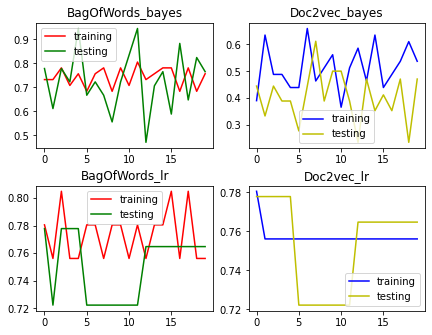

In [245]:
import matplotlib.pyplot as plt
fig,ax_list = plt.subplots(nrows=2,ncols=2)
ax_list[0][0].title.set_text('BagOfWords_bayes')
ax_list[0][0].plot(range(cv),bayes_scores_train,'r',label = 'training')
ax_list[0][0].plot(range(cv),bayes_scores_test,'g',label = 'testing')

ax_list[0][1].title.set_text('Doc2vec_bayes')
ax_list[0][1].plot(range(cv),bayes_scores_train_doc2vec,'b',label = 'training')
ax_list[0][1].plot(range(cv),bayes_scores_test_doc2vec,'y',label = 'testing')

ax_list[1][0].title.set_text('BagOfWords_lr')
ax_list[1][0].plot(range(cv),lr_scores_train,'r',label = 'training')
ax_list[1][0].plot(range(cv),lr_scores_test,'g',label = 'testing')

ax_list[1][1].title.set_text('Doc2vec_lr')
ax_list[1][1].plot(range(cv),lr_scores_train_doc2vec,'b',label = 'training')
ax_list[1][1].plot(range(cv),lr_scores_test_doc2vec,'y',label = 'testing')

ax_list[0][0].legend(loc='best')
ax_list[0][1].legend(loc='best')
ax_list[1][0].legend(loc='best')
ax_list[1][1].legend(loc='best')
plt.subplots_adjust(left=0.1, right=1, bottom=1, top=2, wspace=0.2, hspace=0.3) # 调整子图之间的位置
plt.show()

### 迁移学习的准确率

In [210]:

print('doc2vec_lr_迁移学习训练集准确率：',lr_doc2vec.score(doc2vec_train_array_dx,ytrain))
print('doc2vec_lr_迁移学习测试集准确率：',lr_doc2vec.score(doc2vec_test_array_dx,ytest))
print('doc2vec_bayes_迁移学习训练集准确率',bayes_doc2vec.score(doc2vec_train_array_dx,ytrain)) 
print('doc2vec_bayes_迁移学习测试集准确率',bayes_doc2vec.score(doc2vec_test_array_dx,ytest))

doc2vec_lr_迁移学习训练集准确率： 0.7573170731707317
doc2vec_lr_迁移学习测试集准确率： 0.7528409090909091
doc2vec_bayes_迁移学习训练集准确率 0.7573170731707317
doc2vec_bayes_迁移学习测试集准确率 0.7528409090909091


# NN Model

In [211]:
import tensorflow as tf
from keras.utils.np_utils import to_categorical
y_train = to_categorical(ytrain,num_classes = len(np.unique(ytrain)))
y_test = to_categorical(ytest,num_classes = len(np.unique(ytest)))

In [212]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# 稀疏矩阵转换
# x_train = x_train.toarray()
# x_test = x_test.toarray()

###  构建神经网络模型


In [213]:
input_dim = xtrain_array.shape[1] # 特征数量

model = Sequential()
model.add(tf.keras.Input(shape = (input_dim,))) # 输入层
model.add(layers.Dense(units = 100, activation = 'relu')) # 100个神经元
model.add(layers.Dense(len(np.unique(ytrain)),activation = 'sigmoid')) # 2表示最后一层我想得到2个特征结果,有多少个分类结果就有多少个神经元

# 定义Loss-function优化器
model.compile(loss = 'binary_crossentropy'  # 交叉熵损失
                ,optimizer = 'adam'
                ,metrics = ['accuracy'])
model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 100)               181000    
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 202       
Total params: 181,202
Trainable params: 181,202
Non-trainable params: 0
_________________________________________________________________


In [214]:
with tf.device('/gpu:0'):
    hist_nn_bag=model.fit(xtrain_array,y_train
        ,epochs = 20,verbose = False    # verbose会打印每次epoch的结果
        ,validation_data = (xtest_array, y_test)
        ,batch_size = 10)

# 模型评估
acc_nn_bag = hist_nn_bag.history['accuracy']     #获取训练集准确性数据
loss_nn_bag = hist_nn_bag.history['loss']

# loss,accuracy = model.evaluate(xtrain_array,y_train,verbose = True)
# print('训练数据集准确率为',accuracy)
# loss,accuracy = model.evaluate(xtest_array,y_test,verbose = True)
# print('测试数据集准确率为',accuracy)

### 使用神经网络拟合doc2vec向量

In [215]:
# 构建神经网络模型
input_dim = doc2vec_train_array.shape[1] # 特征数量

model = Sequential()
model.add(tf.keras.Input(shape = (input_dim,)))
model.add(layers.Dense(100, activation = 'relu')) # 100表示第一层我想得到100个特征
model.add(layers.Dense(len(np.unique(ytrain)),activation = 'sigmoid')) # 2表示最后一层我想得到2个特征结果,有多少个分类结果就有多少个神经元

# 定义Loss-function优化器
model.compile(loss = 'binary_crossentropy'  # 交叉熵损失
                ,optimizer = 'adam'
                ,metrics = ['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 100)               9000      
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 202       
Total params: 9,202
Trainable params: 9,202
Non-trainable params: 0
_________________________________________________________________


In [216]:
with tf.device('/gpu:0'):
    hist_nn_doc2vec=model.fit(doc2vec_train_array,y_train
        ,epochs = 20,verbose =False    # verbose会打印每次epoch的结果
        ,validation_data = (doc2vec_test_array, y_test)
        ,batch_size = 10)
# 模型评估
acc_nn_doc2vec = hist_nn_doc2vec.history['accuracy']     
loss_nn_doc2vec = hist_nn_doc2vec.history['loss']


#LSTM模型

In [217]:
# LSTM
from tensorflow.keras.layers import Embedding,LSTM,Dropout,Dense

input_length = doc2vec_train_array.shape[0]
vocab_dim = doc2vec_train_array.shape[1]
# n_symbols = data['label'].unique()

model = Sequential()
model.add(Embedding(input_dim = len(dictionary_1)+1,
                   output_dim = vocab_dim,
                   mask_zero = True,
                   input_length = input_length))
model.add(LSTM(activation = 'tanh',units = 50))
model.add(Dropout(0.5))
model.add(Dense(2,activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',metrics =['accuracy'])


In [218]:
print('Train...')
with tf.device('/gpu:0'): 
  hist_lstm_doc2vec = model.fit(doc2vec_train_array,y_train,batch_size = 100,epochs = 20,verbose = False)

# 模型评估
acc_lstm_doc2vec = hist_lstm_doc2vec.history['accuracy']     
loss_lstm_doc2vec = hist_lstm_doc2vec.history['loss']

Train...


In [219]:
print('xtrain_array_Train...')
with tf.device('/gpu:0'): 
  hist_lstm_bag = model.fit(xtrain_array,y_train,batch_size = 100,epochs = 20,verbose = False)

# 模型评估
acc_lstm_bag = hist_lstm_bag.history['accuracy']     
loss_lstm_bag = hist_lstm_bag.history['loss']



xtrain_array_Train...


### 画图

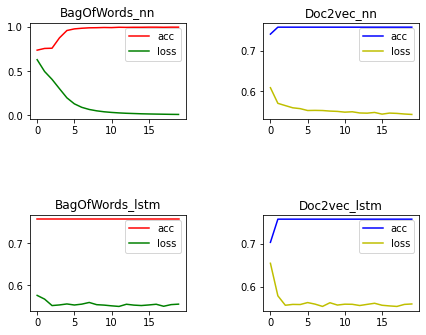

In [235]:
import matplotlib.pyplot as plt
fig,ax_list = plt.subplots(nrows=2,ncols=2)
ax_list[0][0].title.set_text('BagOfWords_nn')
ax_list[0][0].plot(range(cv),acc_nn_bag,'r',label = 'acc')
ax_list[0][0].plot(range(cv),loss_nn_bag,'g',label = 'loss')

ax_list[0][1].title.set_text('Doc2vec_nn')
ax_list[0][1].plot(range(cv),acc_nn_doc2vec,'b',label = 'acc')
ax_list[0][1].plot(range(cv),loss_nn_doc2vec,'y',label = 'loss')

ax_list[1][0].title.set_text('BagOfWords_lstm')
ax_list[1][0].plot(range(cv),acc_lstm_bag,'r',label = 'acc')
ax_list[1][0].plot(range(cv),loss_lstm_bag,'g',label = 'loss')

ax_list[1][1].title.set_text('Doc2vec_lstm')
ax_list[1][1].plot(range(cv),acc_lstm_doc2vec,'b',label = 'acc')
ax_list[1][1].plot(range(cv),loss_lstm_doc2vec,'y',label = 'loss')
plt.subplots_adjust(left=0.1, right=1, bottom=1, top=2, wspace=0.5, hspace=1) # 调整子图之间的位置
ax_list[0][0].legend(loc = 'best')
ax_list[0][1].legend(loc = 'best')
ax_list[1][0].legend(loc = 'best')
ax_list[1][1].legend(loc = 'best')

plt.show()

# 结果说明

In [221]:
# 机器学习各模型效果如下：

'''
首先，使用5000个样本进行训练，得到以下结果：
使用词袋模型得到的词向量，在朴素贝叶斯分类器下的训练集准确率为95%，测试集准确率为75%
使用词嵌入模型得到的词向量，在朴素贝叶斯分类器下的训练集准确率为51%，测试集准确率为50%

使用词袋模型得到的词向量，在逻辑回归分类器下的训练集准确率为80%，测试集准确率为75%
使用词嵌入模型得到的词向量，在逻辑回归分类器下的训练集准确率为76%，测试集准确率为75%

使用词袋模型得到的词向量，在神经网络分类器下的训练集准确率为99%，测试集准确率为82%
使用词嵌入模型得到的词向量，在神经网络分类器下的训练集准确率为76%，测试集准确率为75%

使用词袋模型得到的词向量，在LSTM分类器下的训练集准确率为76%，测试集准确率为75%
使用词嵌入模型得到的词向量，在LSTM分类器下的训练集准确率为75%，测试集准确率为75%

迁移学习的效果：
bayes、lr、nn、LSTM 均为75%的准确率

随后使用十倍的样本进行训练，得到的结果完全一致，说明5000的样本量已经可以满足模型的学习，继续添加样本量也不能提高模型的学习能力了：
'''

'\n首先，使用5000个样本进行训练，得到以下结果：\n使用词袋模型得到的词向量，在朴素贝叶斯分类器下的训练集准确率为95%，测试集准确率为75%\n使用词嵌入模型得到的词向量，在朴素贝叶斯分类器下的训练集准确率为51%，测试集准确率为50%\n\n使用词袋模型得到的词向量，在逻辑回归分类器下的训练集准确率为80%，测试集准确率为75%\n使用词嵌入模型得到的词向量，在逻辑回归分类器下的训练集准确率为76%，测试集准确率为75%\n\n使用词袋模型得到的词向量，在神经网络分类器下的训练集准确率为99%，测试集准确率为82%\n使用词嵌入模型得到的词向量，在神经网络分类器下的训练集准确率为76%，测试集准确率为75%\n\n使用词袋模型得到的词向量，在LSTM分类器下的训练集准确率为76%，测试集准确率为75%\n使用词嵌入模型得到的词向量，在LSTM分类器下的训练集准确率为75%，测试集准确率为75%\n\n迁移学习的效果：\nbayes、lr、nn、LSTM 均为75%的准确率\n\n随后使用十倍的样本进行训练，得到的结果完全一致，说明5000的样本量已经可以满足模型的学习，继续添加样本量也不能提高模型的学习能力了：\n'

# 模型间效果对比

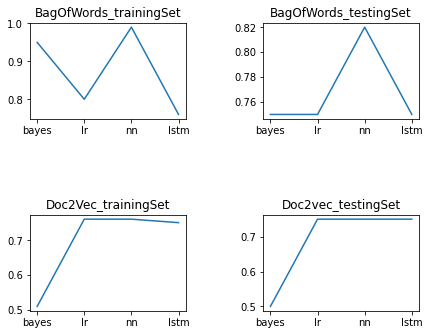

In [222]:
import matplotlib.pyplot as plt
fig,ax_list = plt.subplots(nrows=2,ncols=2)
ax_list[0][0].title.set_text('BagOfWords_trainingSet')
ax_list[0][0].plot(['bayes','lr','nn','lstm'],[0.95,0.80,0.99,0.76])
# plt.subplot(412)
ax_list[0][1].title.set_text('BagOfWords_testingSet')
ax_list[0][1].plot(['bayes','lr','nn','lstm'],[0.75,0.75,0.82,0.75])
# plt.subplot(413)
ax_list[1][0].title.set_text('Doc2Vec_trainingSet')
ax_list[1][0].plot(['bayes','lr','nn','lstm'],[0.51,0.76,0.76,0.75])
# plt.subplot(414)
ax_list[1][1].title.set_text('Doc2vec_testingSet')
ax_list[1][1].plot(['bayes','lr','nn','lstm'],[0.50,0.75,0.75,0.75])

plt.subplots_adjust(left=0.1, right=1, bottom=1, top=2, wspace=0.5, hspace=1) # 调整子图之间的位置
plt.show()

# 从图中我们可以看出，不论是在词袋模型还是词嵌入模型下，简单的神经网络模型效果总是优于传统机器学习方法和LSTM，由于LSTM在处理较长文本时，能够发挥出其结构上的优势，因此在短文本中效果略低是可以理解的。

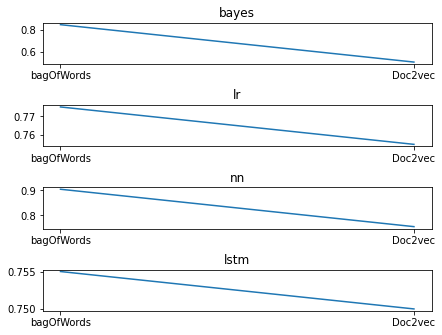

In [223]:
plt.subplot(411)
plt.title('bayes')
plt.plot(['bagOfWords','Doc2vec'],[(0.95+0.75)/2,(0.51+0.50)/2])
plt.subplot(412)
plt.title('lr')
plt.plot(['bagOfWords','Doc2vec'],[(0.75+0.80)/2,(0.76+0.75)/2])
plt.subplot(413)
plt.title('nn')
plt.plot(['bagOfWords','Doc2vec'],[(0.99+0.82)/2,(0.76+0.75)/2])
plt.subplot(414)
plt.title('lstm')
plt.plot(['bagOfWords','Doc2vec'],[(0.76+0.75)/2,(0.75+0.75)/2])

plt.subplots_adjust(left=0.1, right=1, bottom=1, top=2, wspace=10, hspace=1) # 调整子图之间的位置
plt.show()

# 从图中效果来看，词袋模型的效果在所有模型上都优于词嵌入模型，原因在于，样本中的文本非常短，使用词袋模型并没有产生稀疏问题，反而非常简洁高效，而词嵌入模型更加适合有篇幅的文章、长句等，才得以从大量的上下文中学习到更多知识。因此在短文本效果上表现一般。

In [223]:
'''End'''